In [1]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
import spacy
nlp = spacy.load('en_core_web_sm')
device = torch.device("mps")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/aadityajoshi/Downloads/DATASET.csv')

In [3]:
df.head()

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
blanks = []
for i,text,lb in df.itertuples():
    if type(text) == str:
        if text.isspace() == True:
            blanks.append(i)
print(blanks)
df.drop(blanks,inplace=True)

[]


In [6]:
df['text'] = df['Review']
df.drop('Review',axis=1,inplace=True)

In [7]:
def clean_lemm(text):
    doc = nlp(text.lower())
    clean_text = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(clean_text)

In [8]:
df['text'] = df['text'].apply(clean_lemm)

In [9]:
df['len'] = df['text'].apply(len)

In [10]:
df['text'].head()

0    great music service audio high quality app eas...
1    ignore previous negative rating app super grea...
2    pop good spotify experience android 12 annoyin...
3                          buggy terrible use recently
4              dear spotify song playlist shuffle play
Name: text, dtype: object

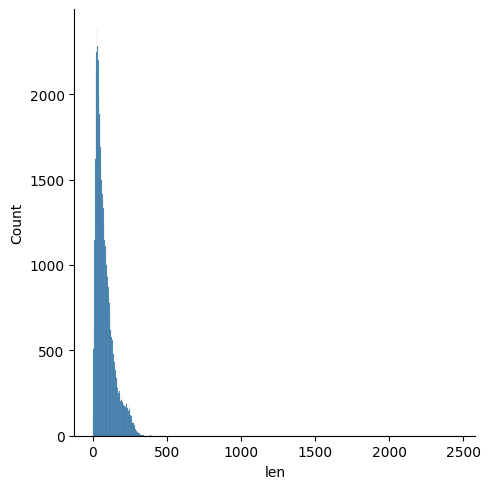

In [11]:
sns.displot(df['len'])

<Axes: xlabel='label', ylabel='count'>

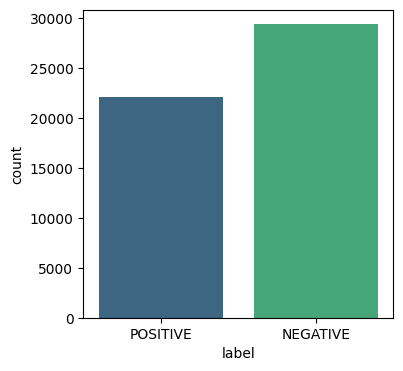

In [12]:
plt.figure(figsize=(4,4))
sns.countplot(x='label',data=df,palette='viridis')

In [13]:
df['label'] = df['label'].replace({"POSITIVE":1,"NEGATIVE":0})

In [14]:
df['len'].quantile(0.999)

324.52900000000227

In [15]:
ind_len = list(df[df['len']>=350].index)
for i in ind_len:
    df['text'].loc[i] = df['text'].loc[i][:350]
df['len'] = df['text'].apply(len)

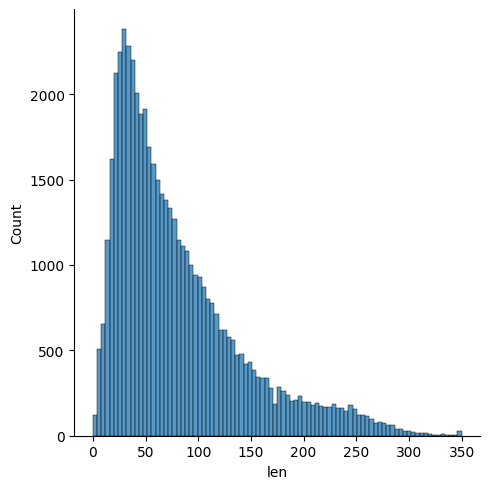

In [16]:
sns.displot(df['len'])

In [17]:
def spacy_tokenizer(text):
    clean_text = clean_lemm(text)
    return clean_text.split()

In [18]:
def build_vocab(text_iterator,specials=('<unk>','<pad>'),min_freq=1):
    token_count = defaultdict(int)
    for text in text_iterator:
        for token in spacy_tokenizer(text):
            token_count[token] += 1
    vocab = {token : idx for idx,(token,count) in enumerate(token_count.items()) if count>=min_freq}
    for special in specials:
        if special not in token_count:
            vocab[special] = len(vocab)
    return vocab,len(vocab)

In [19]:
vocab,vocab_size = build_vocab(df['text'])
print(vocab_size)

22462


In [20]:
text_pipeline = lambda x : [vocab.get(token,vocab['<unk>']) for token in spacy_tokenizer(x)]
label_pipeline = lambda x : int(x)

In [21]:
class TextDataset(Dataset):
    def __init__(self,df,text_pipeline,label_pipeline):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline
    def __len__(self):
        return len(self.texts)
    def __getitem__(self,idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return self.text_pipeline(text),self.label_pipeline(label)

In [22]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.33,stratify=df['label'],random_state=42)

In [23]:
train_dataset = TextDataset(train_df,text_pipeline,label_pipeline)
test_dataset = TextDataset(test_df,text_pipeline,label_pipeline)

In [24]:
def pad_collate(batch):
    text_list = []
    label_list = []
    for text,label in batch:
        text_list.append(torch.LongTensor(text))
        label_list.append(label)
    text_list = pad_sequence(text_list,batch_first=True)
    label_list = torch.LongTensor(label_list)
    return text_list.to(device),label_list.to(device)

In [66]:
train_batch_size = 512
test_batch_size = 512
train_loader = DataLoader(train_dataset,train_batch_size,shuffle=True,collate_fn=pad_collate)
test_loader = DataLoader(test_dataset,test_batch_size,shuffle=False,collate_fn=pad_collate)

In [26]:
class LSTM(nn.Module):
    def __init__(self,vocab_size,embedding_size,hidden_size,out_size=2,num_layers=1,bidirectional=True,p=0.4):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_dir = 2 if bidirectional else 1
        self.dropout = nn.Dropout(p)
        self.emebdding = nn.Embedding(vocab_size,embedding_size)
        self.lstm = nn.LSTM(embedding_size,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir*self.hidden_size,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.emebdding(x)
        lstm_out,hidden = self.lstm(embeddings,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [73]:
model = LSTM(vocab_size,128,32,2,3,bidirectional=False).to(device)

In [74]:
model

LSTM(
  (dropout): Dropout(p=0.4, inplace=False)
  (emebdding): Embedding(22462, 128)
  (lstm): LSTM(128, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [75]:
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [76]:
import time
from tqdm import tqdm

start = time.time()
for epoch in range(num_epochs):
    model.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = model(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/10: 100%|██████████████████| 68/68 [00:58<00:00,  1.16it/s, loss=0.6889]


Epoch 1/10, Average Loss: 0.6844


Epoch 2/10: 100%|██████████████████| 68/68 [00:59<00:00,  1.15it/s, loss=0.5741]


Epoch 2/10, Average Loss: 0.6461


Epoch 3/10: 100%|██████████████████| 68/68 [00:59<00:00,  1.13it/s, loss=0.4708]


Epoch 3/10, Average Loss: 0.4270


Epoch 4/10: 100%|██████████████████| 68/68 [00:59<00:00,  1.14it/s, loss=0.3844]


Epoch 4/10, Average Loss: 0.3498


Epoch 5/10: 100%|██████████████████| 68/68 [00:59<00:00,  1.15it/s, loss=0.3864]


Epoch 5/10, Average Loss: 0.3200


Epoch 6/10: 100%|██████████████████| 68/68 [00:59<00:00,  1.15it/s, loss=0.3277]


Epoch 6/10, Average Loss: 0.2914


Epoch 7/10: 100%|██████████████████| 68/68 [00:59<00:00,  1.15it/s, loss=0.2572]


Epoch 7/10, Average Loss: 0.2710


Epoch 8/10: 100%|██████████████████| 68/68 [00:59<00:00,  1.15it/s, loss=0.2785]


Epoch 8/10, Average Loss: 0.2493


Epoch 9/10: 100%|██████████████████| 68/68 [00:59<00:00,  1.15it/s, loss=0.2157]


Epoch 9/10, Average Loss: 0.2320


Epoch 10/10: 100%|█████████████████| 68/68 [00:58<00:00,  1.16it/s, loss=0.1550]

Epoch 10/10, Average Loss: 0.2147
Total training time: 9.88 minutes


In [77]:
from sklearn.metrics import classification_report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = model(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      9684
           1       0.83      0.85      0.84      7302

    accuracy                           0.86     16986
   macro avg       0.86      0.86      0.86     16986
weighted avg       0.86      0.86      0.86     16986



### BiLSTM

In [56]:
class LSTM(nn.Module):
    def __init__(self,vocab_size,embedding_size,hidden_size,out_size=2,num_layers=1,bidirectional=True,p=0.4):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_dir = 2 if bidirectional else 1
        self.dropout = nn.Dropout(p)
        self.emebdding = nn.Embedding(vocab_size,embedding_size)
        self.lstm = nn.LSTM(embedding_size,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir*self.hidden_size,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.emebdding(x)
        lstm_out,hidden = self.lstm(embeddings,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [63]:
Bilstm = LSTM(vocab_size,64,32,out_size=2,num_layers=1,bidirectional=True).to(device)

In [70]:
num_epoch = 5
opt_2 = torch.optim.Adam(Bilstm.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

In [71]:
import time
from tqdm import tqdm

start = time.time()
for epoch in range(num_epochs):
    Bilstm.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        opt_2.zero_grad()
        y_pred = Bilstm(text)
        loss = criterion(y_pred, label)
        loss.backward()
        opt_2.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/10: 100%|██████████████████| 68/68 [00:58<00:00,  1.16it/s, loss=0.1625]


Epoch 1/10, Average Loss: 0.1411


Epoch 2/10: 100%|██████████████████| 68/68 [00:58<00:00,  1.17it/s, loss=0.1074]


Epoch 2/10, Average Loss: 0.1226


Epoch 3/10: 100%|██████████████████| 68/68 [00:58<00:00,  1.16it/s, loss=0.0804]


Epoch 3/10, Average Loss: 0.1103


Epoch 4/10: 100%|██████████████████| 68/68 [00:58<00:00,  1.16it/s, loss=0.0728]


Epoch 4/10, Average Loss: 0.1004


Epoch 5/10: 100%|██████████████████| 68/68 [00:57<00:00,  1.18it/s, loss=0.0974]


Epoch 5/10, Average Loss: 0.0961


Epoch 6/10: 100%|██████████████████| 68/68 [00:57<00:00,  1.18it/s, loss=0.0670]


Epoch 6/10, Average Loss: 0.0897


Epoch 7/10: 100%|██████████████████| 68/68 [00:57<00:00,  1.19it/s, loss=0.0805]


Epoch 7/10, Average Loss: 0.0796


Epoch 8/10: 100%|██████████████████| 68/68 [00:57<00:00,  1.19it/s, loss=0.0940]


Epoch 8/10, Average Loss: 0.0758


Epoch 9/10: 100%|██████████████████| 68/68 [00:57<00:00,  1.19it/s, loss=0.0146]


Epoch 9/10, Average Loss: 0.0650


Epoch 10/10: 100%|█████████████████| 68/68 [00:57<00:00,  1.17it/s, loss=0.0534]

Epoch 10/10, Average Loss: 0.0675
Total training time: 9.67 minutes


In [72]:
from sklearn.metrics import classification_report
all_preds = []
all_labels = []

Bilstm.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = Bilstm(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      9684
           1       0.81      0.83      0.82      7302

    accuracy                           0.84     16986
   macro avg       0.84      0.84      0.84     16986
weighted avg       0.84      0.84      0.84     16986

